In [190]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels as sm
import yfinance as yf
import datetime as dt
import sys
import yaml
from pandas_datareader import data as wb
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from colorama import Fore
from datetime import datetime, timedelta
from utils import ADX, rsi, MACD, slope, ATR, get_last_date

plt.style.use(['science','notebook','grid'])
#plt.style.available

pd.options.mode.chained_assignment = None 

In [193]:
# StartDate Function
startdate = (datetime.today() - timedelta(days=720)).strftime('%Y-%m-%d')

with open("../info/info.yaml", "r") as stream:
    tics = yaml.load(stream, Loader=yaml.FullLoader)
    tickers = tics['tickers']

In [194]:
%%time

sec_data_concat = pd.DataFrame()

len_tickers = len(tickers)
estimated_time = len(tickers)*1.7/60

fails = 0
success = 0
fail_list = []

print(Fore.CYAN + "==> Data Load Started" )
print(f"{' '*4}Estimated Time: {estimated_time:.1f} minute(s) for {len_tickers} tickers  \n" + Fore.WHITE)

for t in tickers: 
    try:
            sec_data = pd.DataFrame()
            sec_data = wb.DataReader(t, data_source='yahoo', start = startdate)#,session=session)
            sec_data.reset_index(level=0, inplace=True)
                             
            sec_data['Stock'] = t
                        
            sec_data_concat = pd.concat([sec_data_concat,sec_data])
            
            
            ##############################################################################
            # PRINTING LOAD STATUS
            ##############################################################################
            
            
            success = success + 1
            left_to_load = len_tickers - success - fails
            time_left = left_to_load*1.7/60
            completion = (fails+success)/len(tickers)
            
            print('+++ Data Load' + Fore.GREEN + ' Complete [✓] ' + Fore.WHITE + f'for {t}   {completion:.1%}   {time_left:.1f} minutes')     
          
            
    except Exception as e: 
            fails = fails + 1
            left_to_load = len_tickers - success - fails
            time_left = left_to_load*1.7/60
            fail_list.append(t)
            completion = (fails+success)/len(tickers)
            
            print('--- Data Load' + Fore.RED + ' Failed   [x] ' + Fore.WHITE + f'for {t}   {completion:.1%}   {time_left:.1f} minutes')
            
    
print('\nSuccess: ' + Fore.GREEN + f'{success}    ' + Fore.WHITE + 'Failed: ' + Fore.RED + f'{fails} \n' + Fore.WHITE)
print("List of Fails: \n" + Fore.RED + f'{fail_list}' + Fore.WHITE, '\n\n' )  



==> Data Load Started
    Estimated Time: 3.9 minute(s) for 139 tickers  

+++ Data Load Complete [✓] for ^BVSP   0.7%   23.0 minutes
+++ Data Load Complete [✓] for VALE3.SA   1.4%   22.8 minutes
+++ Data Load Complete [✓] for VIIA3.SA   2.2%   22.7 minutes
+++ Data Load Complete [✓] for PETR4.SA   2.9%   22.5 minutes
+++ Data Load Complete [✓] for BBDC4.SA   3.6%   22.3 minutes
+++ Data Load Complete [✓] for ITUB4.SA   4.3%   22.2 minutes
+++ Data Load Complete [✓] for MGLU3.SA   5.0%   22.0 minutes
+++ Data Load Complete [✓] for COGN3.SA   5.8%   21.8 minutes
+++ Data Load Complete [✓] for B3SA3.SA   6.5%   21.7 minutes
+++ Data Load Complete [✓] for BBAS3.SA   7.2%   21.5 minutes
+++ Data Load Complete [✓] for IRBR3.SA   7.9%   21.3 minutes
+++ Data Load Complete [✓] for ABEV3.SA   8.6%   21.2 minutes
+++ Data Load Complete [✓] for OIBR3.SA   9.4%   21.0 minutes
+++ Data Load Complete [✓] for AZUL4.SA   10.1%   20.8 minutes
+++ Data Load Complete [✓] for CIEL3.SA   10.8%   20.7 minu

In [159]:
print(f'{" "*2}Hello')

  Hello


In [119]:
success_list = [x for x in tickers if x not in fail_list]
sec_data_final = pd.DataFrame()

for s in success_list:
    
    sec_data_temp = sec_data_concat[sec_data_concat['Stock'] == s]
    
    sec_data_temp['LastPrice'] = sec_data_temp.loc[:, ('Adj Close')].shift(1)
    sec_data_temp['PctReturn'] = ( sec_data_temp['Adj Close']/sec_data_temp['LastPrice'] )-1
    sec_data_temp['LogReturn'] = np.log(sec_data_temp['Adj Close'] / sec_data_temp['Adj Close'].shift(1))
    sec_data_temp['IFR_2'] = rsi(sec_data_temp,2)
    sec_data_temp['IFR'] = rsi(sec_data_temp,9)
    
    sec_data_final = pd.concat([sec_data_final,sec_data_temp])
  
sec_data_final

,Date,High,Low,Open,Close,Volume,Adj Close,Stock,LastPrice,PctReturn,LogReturn,IFR_2,IFR
0,2020-01-02,54.439999,53.750000,53.980000,54.330002,17509700.0,42.689384,VALE3.SA,NaN,NaN,NaN,NaN,NaN
1,2020-01-03,54.500000,53.580002,53.680000,53.930000,17284800.0,42.375092,VALE3.SA,42.689384,-0.007362,-0.007390,NaN,NaN
2,2020-01-06,53.799999,53.150002,53.799999,53.610001,32787800.0,42.123653,VALE3.SA,42.375092,-0.005934,-0.005951,NaN,NaN
3,2020-01-07,54.189999,53.400002,53.500000,54.000000,16326400.0,42.430092,VALE3.SA,42.123653,0.007275,0.007248,61.904823,NaN
4,2020-01-08,54.369999,53.619999,54.200001,54.009998,15298500.0,42.437946,VALE3.SA,42.430092,0.000185,0.000185,62.790435,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,2022-07-28,32.630001,31.430000,31.590000,32.290001,114996500.0,32.290001,PETR4.SA,31.350000,0.029984,0.029543,97.896823,79.008465
639,2022-07-29,34.660000,32.830002,33.599998,34.150002,181480600.0,34.150002,PETR4.SA,32.290001,0.057603,0.056005,99.151582,84.966527
640,2022-08-01,34.150002,33.220001,34.000000,33.680000,81365100.0,33.680000,PETR4.SA,34.150002,-0.013763,-0.013858,80.865356,78.695293
641,2022-08-02,34.500000,33.480000,33.770000,33.830002,69147100.0,33.830002,PETR4.SA,33.680000,0.004454,0.004444,82.417701,79.238687


In [188]:
#pd.set_option('display.max_columns', None)
#sec_data_final

sec_last_date = get_last_date(sec_data_final)

sec_last_date.to_csv('..\\sheets\\bovespa_diario_last_date.csv', sep =';', index=False)

sec_last_date

,Date,High,Low,Open,Close,Volume,Adj Close,Stock,LastPrice,PctReturn,LogReturn,IFR_2,IFR
642,2022-08-03,0.0,0.0,0.0,67.519997,0.0,67.519997,VALE3.SA,70.250000,-0.038861,-0.039637,30.097550,36.496798
642,2022-08-03,0.0,0.0,0.0,33.880001,0.0,33.880001,PETR4.SA,33.830002,0.001478,0.001477,83.103085,79.432970


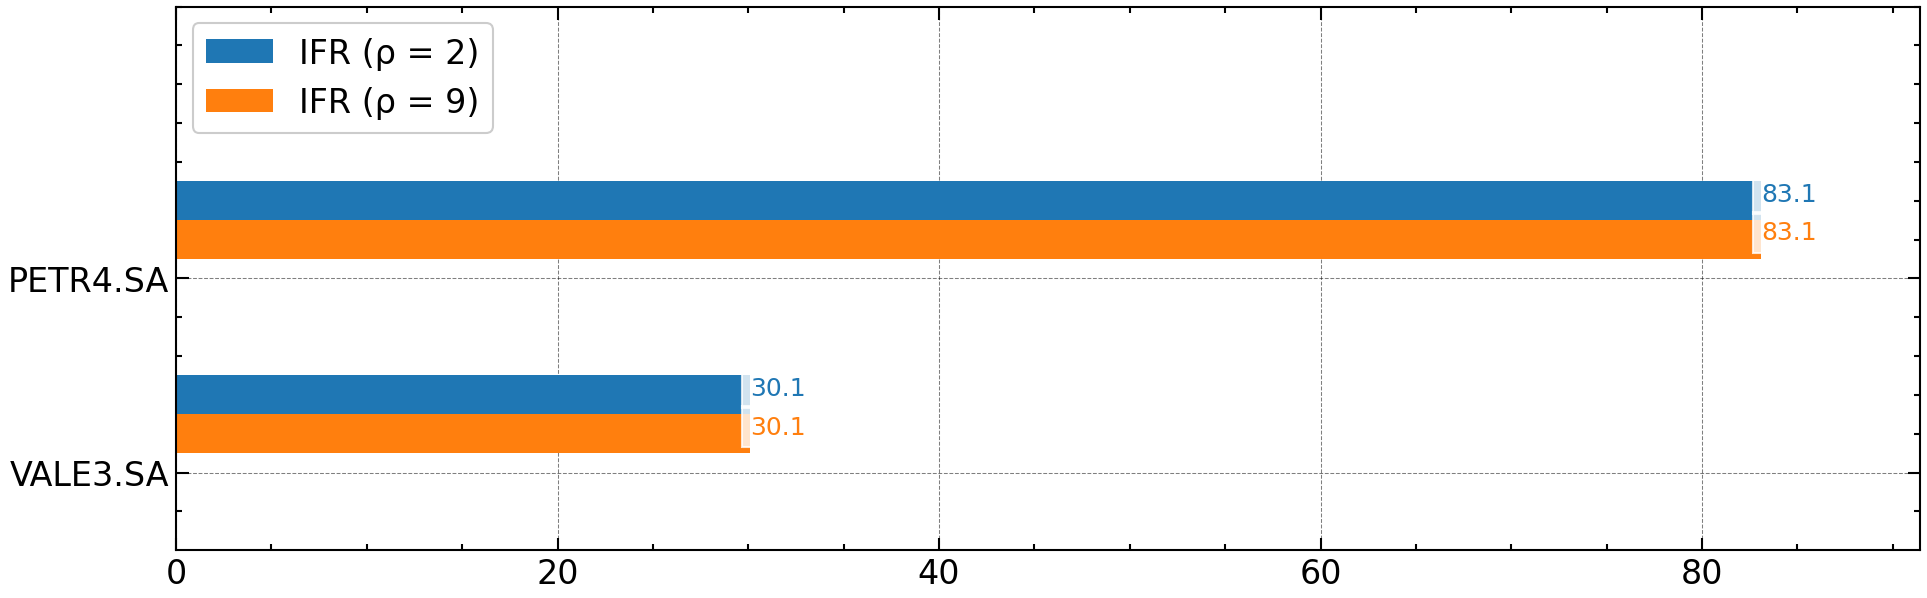

In [189]:
fig, ax = plt.subplots(1,1, figsize=(15,len(tickers)*1.2), dpi=150)
y = sec_last_date.sort_values(by=['IFR_2'],ascending = True)['Stock']
x1 = sec_last_date.sort_values(by=['IFR_2'],ascending = True)['IFR_2'].round(1)
x2 = sec_last_date.sort_values(by=['IFR'],ascending = True)['IFR_2'].round(1)
# x3 = sec_last_date.sort_values(by=['STOCHASTIC_D_SLOW'],ascending = True)['IFR_2'].round(1)

ind   = np.arange(len(y))
width = 0.2

ax.barh(ind, x1, width, color='tab:blue',align='center', label='IFR (\u03C1 = 2)')
ax.barh(ind - width, x2, width, color='tab:orange',align='center', label='IFR (\u03C1 = 9)')
# ax.barh(ind - 2*width, x3, width, color='tab:red',align='center', label='Estochastic D Slow')

ax.set(yticks = ind - 2*width, yticklabels = y, ylim=[width - 1, len(y)], xlim = [0, sec_last_date.IFR_2.max()*1.1])

ax.legend(loc='upper left')

for i, v in enumerate(x1):
    t =  ax.text(v, i, str(v), fontsize = 12, color='tab:blue')
    t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

for i, v in enumerate(x2):
    t=ax.text(v, i-0.2, str(v), fontsize = 12, color='tab:orange')
    t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))
    
#for i, v in enumerate(x3):
#    t=ax.text(v, i-0.8, str(v), fontsize = 12, color='tab:red')
#    t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))
    
plt.show()